In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})


In [3]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [4]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia']
N_STATES_RANGE = range(2, 21)  # 1 to 19 states

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#377eb8',    # Blue
    'paranoia_light': '#6699ff' # Light blue
}


## Figure 2

In [17]:
SAVE_DIR_FIG2 = Path(SAVE_DIR) / "figure2"
SAVE_DIR_FIG2.mkdir(parents=True, exist_ok=True)

In [5]:
def load_data(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics"
    
    # Load metrics
    metrics_path = base_path / f"{group}_metrics.pkl"
    try:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
    except Exception as e:
        print(f"Error loading metrics for {group}, n_state={n_state}: {e}")
        metrics = None
    
    # Load summary
    summary_path = base_path / f"{group}_summary.json"
    try:
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    except Exception as e:
        print(f"Error loading summary for {group}, n_state={n_state}: {e}")
        summary = None
    
    return {'metrics': metrics, 'summary': summary}

def extract_model_metrics(data: Dict) -> Dict:
    """Extract relevant metrics from both metrics and summary files."""
    metrics = {}
    
    try:
        metrics_data = data['metrics']
        summary_data = data['summary']
        
        if metrics_data:
            # Get state frequencies and calculate percentage below threshold
            state_freq_mean = metrics_data['subject_consistency']['summary']['state_frequency']['mean']
            metrics['pct_low_freq'] = np.mean(state_freq_mean < 0.1) * 100
            
            # Get pattern correlations variance
            pattern_corr = metrics_data['subject_consistency']['pattern_correlation']
            state_variances = np.var(pattern_corr, axis=0)
            metrics['max_pattern_var'] = np.max(state_variances)
            
            # Get mean pattern stability
            state_props = metrics_data['state_properties']
            pattern_stabilities = []
            for key in state_props.keys():
                if isinstance(key, (int, str)) and key != 'separability':
                    if isinstance(key, str) and key.isdigit():
                        key = int(key)
                    pattern_stabilities.append(state_props[key]['pattern_stability'])
            metrics['mean_pattern_stability'] = np.mean(pattern_stabilities)
        
        if summary_data:
            # Extract BIC and log-likelihood
            metrics['bic'] = summary_data['model_performance']['bic']
            metrics['log_likelihood'] = summary_data['model_performance']['log_likelihood']
        
    except Exception as e:
        print(f"Error extracting metrics: {e}")
        return None
        
    return metrics

In [24]:
def explore_dict_structure(d, prefix=''):
    """
    Recursively explore and print the structure of nested dictionaries.
    
    Args:
        d: Dictionary or other object to explore
        prefix: String prefix for indentation and nesting
    """
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, (dict, list, np.ndarray)):
                print(f"{prefix}{key}: {type(value)}")
                if isinstance(value, dict):
                    explore_dict_structure(value, prefix + '  ')
                elif isinstance(value, list):
                    print(f"{prefix}  Length: {len(value)}")
                elif isinstance(value, np.ndarray):
                    print(f"{prefix}  Shape: {value.shape}")
            else:
                print(f"{prefix}{key}: {type(value)} = {value}")

# Load and explore one metrics file
group = 'affair'
n_state = 3  # Let's look at the 3-state model
filepath = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics" / f"{group}_metrics.pkl"

print(f"\nExploring structure of metrics file for {group}, n_states={n_state}:")
print(f"File path: {filepath}\n")

with open(filepath, 'rb') as f:
    data = pickle.load(f)
    explore_dict_structure(data)


Exploring structure of metrics file for affair, n_states=3:
File path: /orcd/scratch/bcs/001/yibei/prettymouth/output/affair_hmm_3states_ntw_native_trimmed/statistics/affair_metrics.pkl

state_metrics: <class 'dict'>
  subject_level: <class 'dict'>
    0: <class 'dict'>
      durations: <class 'dict'>
        0: <class 'list'>
          Length: 36
        1: <class 'list'>
          Length: 25
        2: <class 'list'>
          Length: 31
      transitions: <class 'numpy.ndarray'>
        Shape: (3, 3)
      frequencies: <class 'numpy.ndarray'>
        Shape: (3,)
      fractional_occupancy: <class 'numpy.ndarray'>
        Shape: (3,)
      duration_stats: <class 'dict'>
        0: <class 'dict'>
          mean: <class 'numpy.float64'> = 7.583333333333333
          std: <class 'numpy.float64'> = 5.947104804487268
          median: <class 'numpy.float64'> = 5.25
          max: <class 'numpy.float64'> = 25.5
          min: <class 'numpy.float64'> = 1.5
          count: <class 'int'> = 

### 2.1

In [18]:
def create_selection_plot(group: str):
    """Create model selection plot for one group."""
    metrics_data = []
    
    for n_state in N_STATES_RANGE:
        data = load_data(group, n_state)
        if data:
            metrics = extract_model_metrics(data)
            if metrics:
                metrics['n_states'] = n_state
                metrics_data.append(metrics)
    
    df = pd.DataFrame(metrics_data)
    
    # Create figure with one axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # First y-axis: Percentage of low frequency states
    color = COLORS[group]
    ln1 = ax.plot(df['n_states'], df['pct_low_freq'], 
                 color=color, label='% Low Freq States')
    ax.set_xlabel('Number of States')
    ax.set_ylabel('% States with Mean Freq < 0.1', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    
    # Set x-axis to show all integer values
    ax.set_xticks(list(N_STATES_RANGE))
    
    # Second y-axis: Pattern variance
    ax2 = ax.twinx()
    light_color = COLORS[f'{group}_light']
    ln2 = ax2.plot(df['n_states'], df['max_pattern_var'], 
                  color=light_color, linestyle='--', 
                  label='Max Pattern Variance')
    ax2.set_ylabel('Maximum Pattern Variance', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add vertical line at n_state=3
    ax.axvline(x=3, color='gray', linestyle=':', alpha=0.8)
    
    # Combine legends
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')
    
    ax.set_title(f"{group.capitalize()} Group")
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / f'model_selection_{group}.png', dpi=300, bbox_inches='tight')
    plt.close()

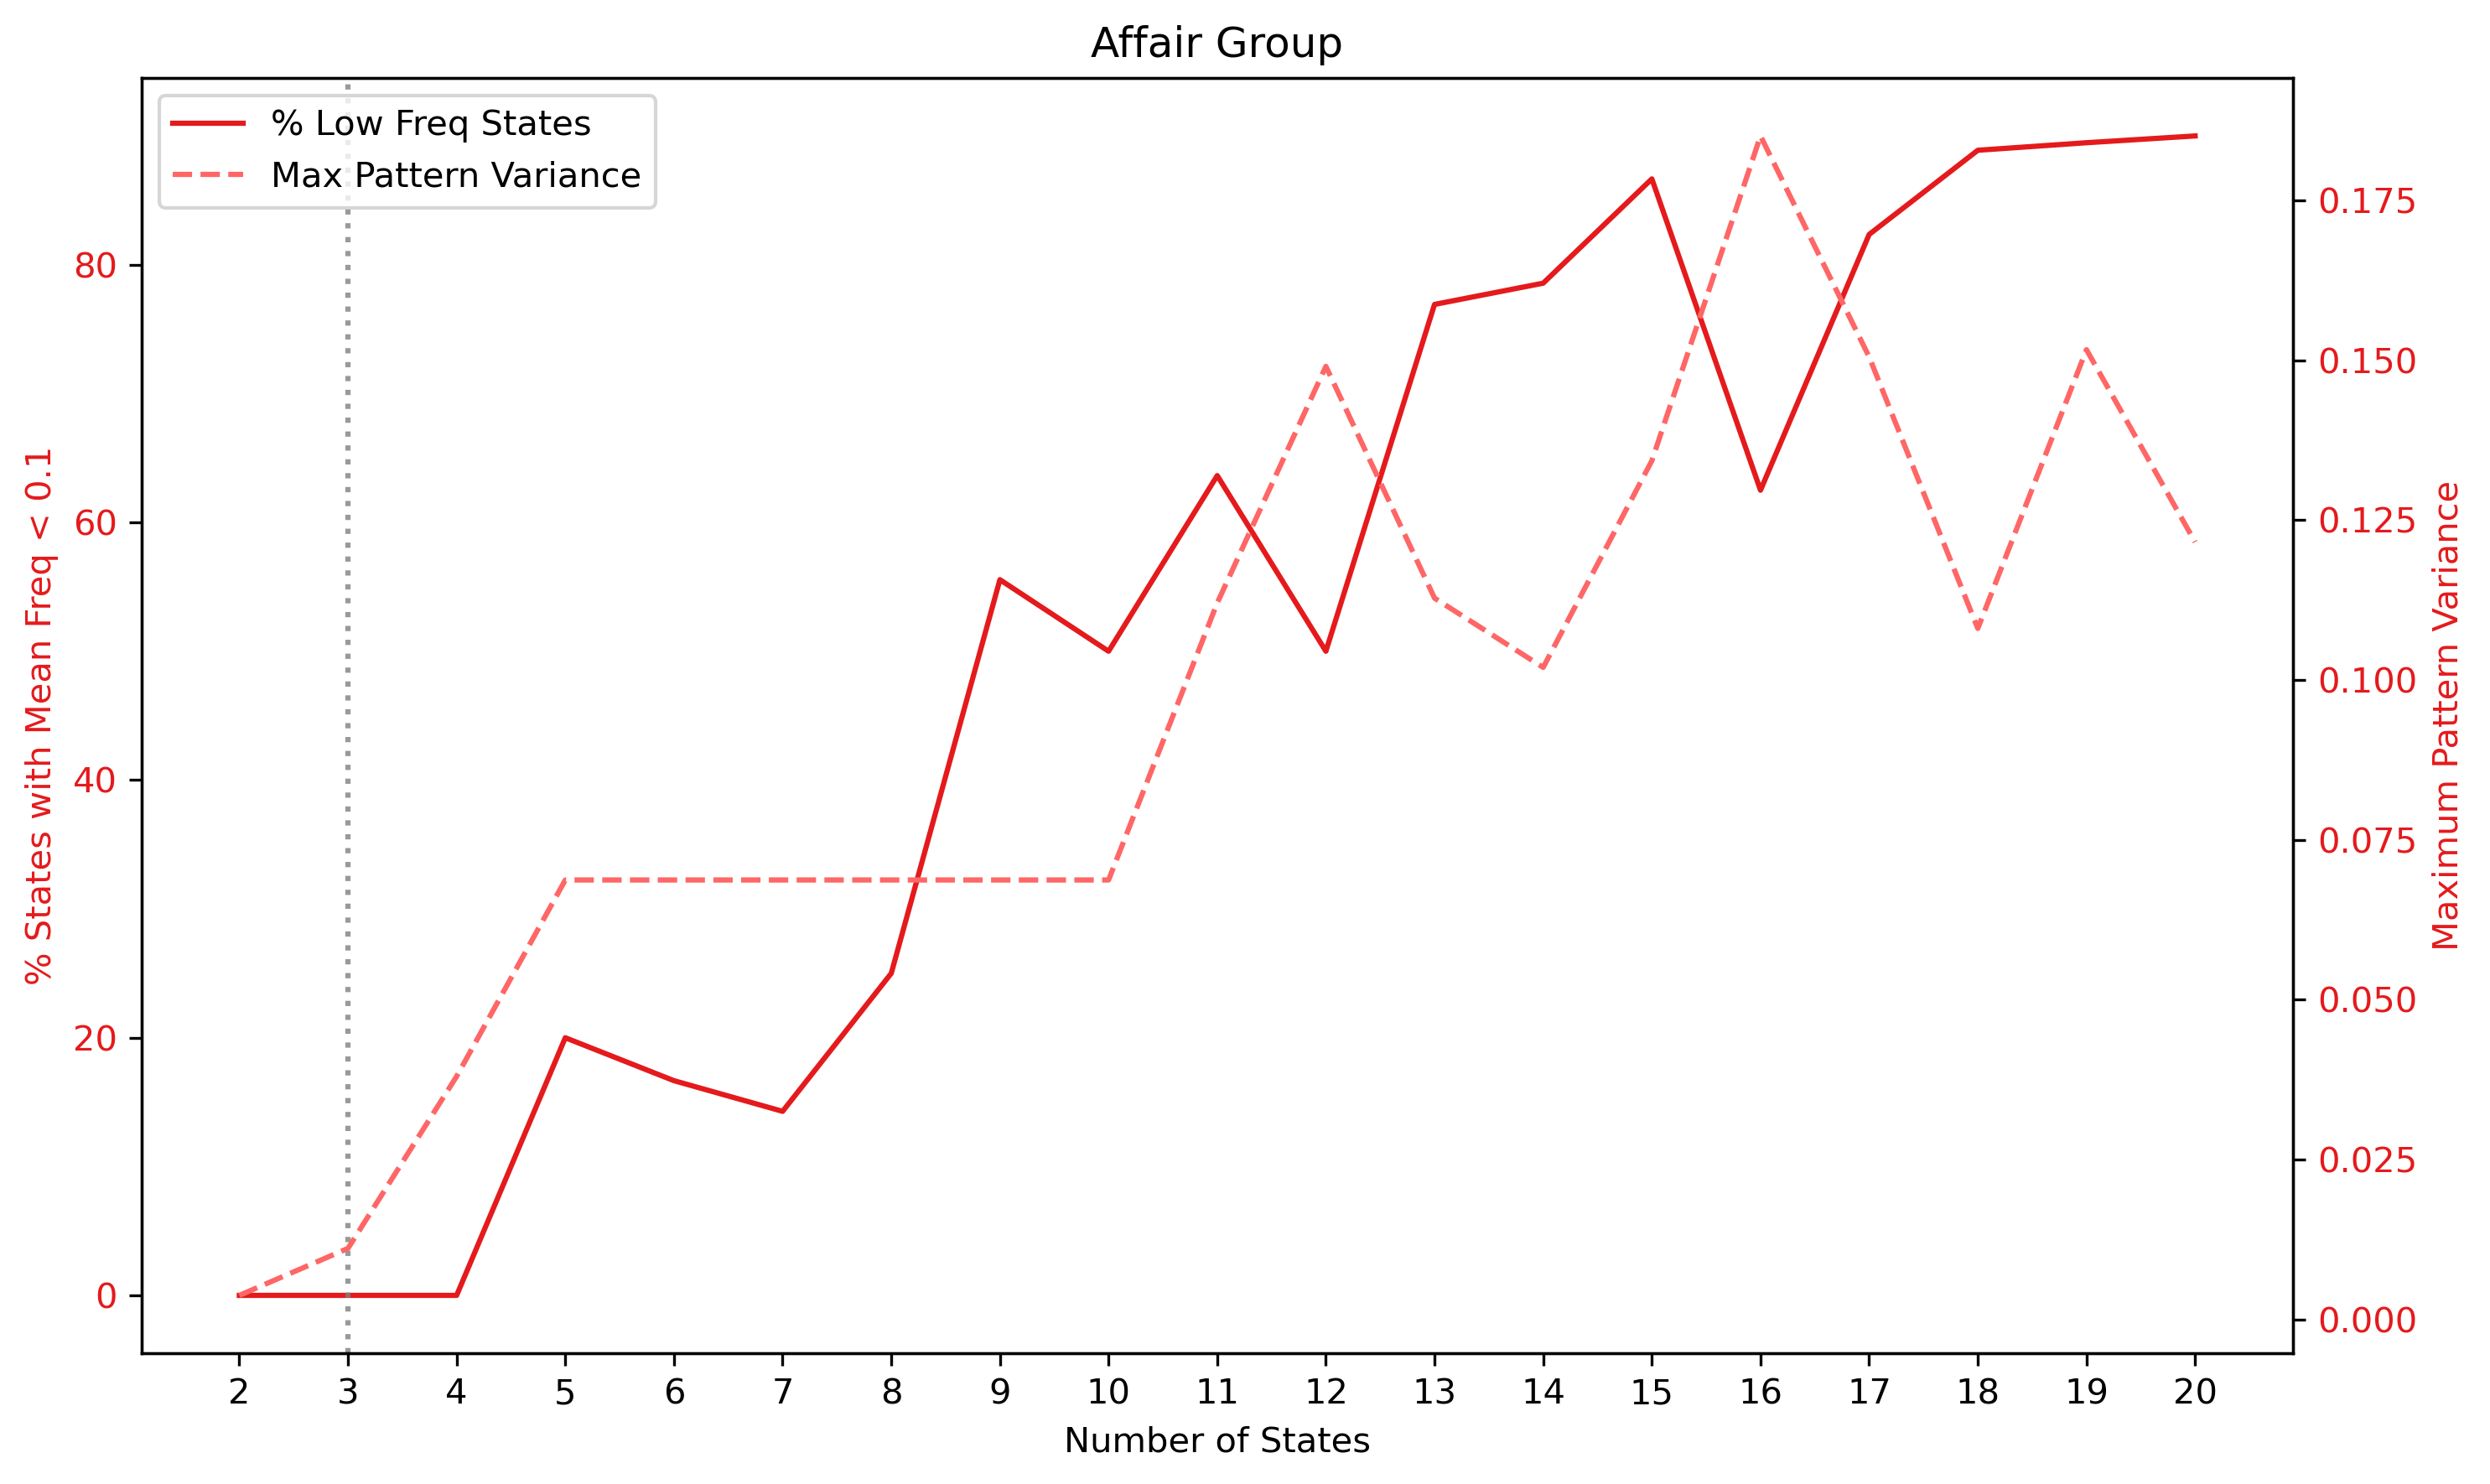

In [19]:
create_selection_plot('affair')

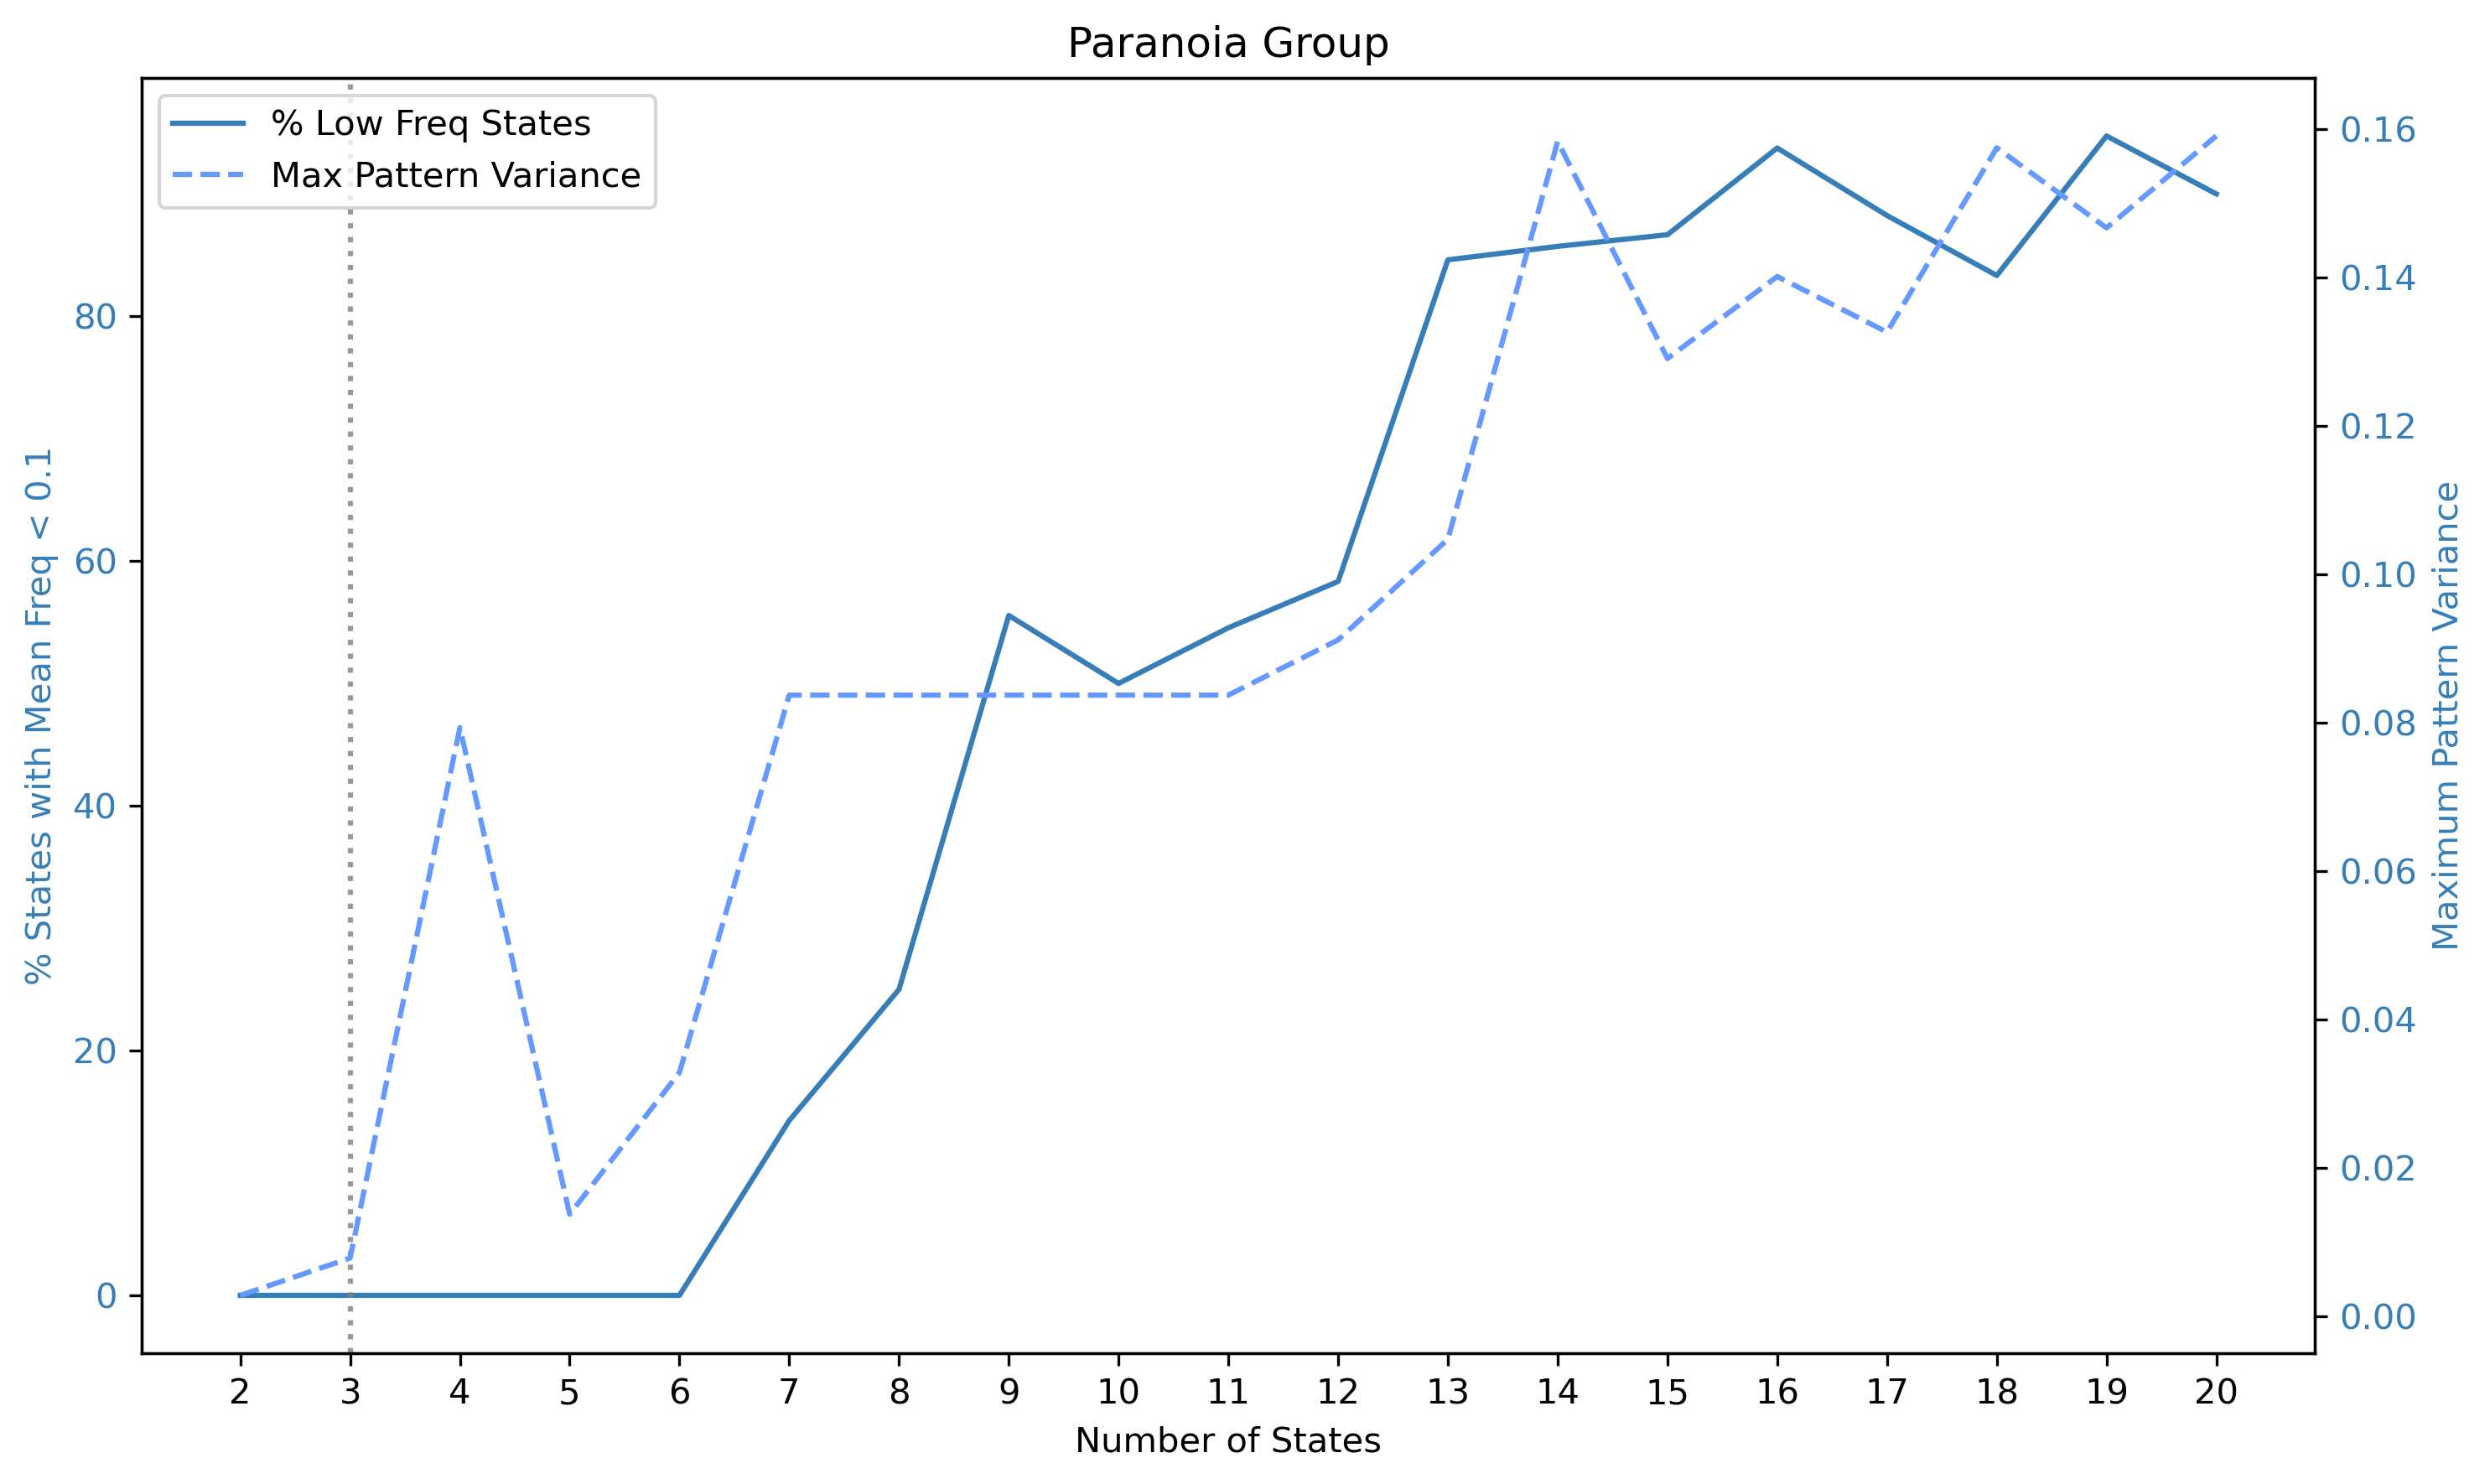

In [20]:
create_selection_plot('paranoia')


In [21]:
def create_model_comparison_plot():
    """Create plot comparing BIC and log-likelihood for both groups with dual y-axes."""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Create second y-axis
    ax2 = ax1.twinx()
    
    # Store lines for legend
    lines = []
    labels = []
    
    for group in GROUPS:
        data = []
        for n_state in N_STATES_RANGE:
            loaded_data = load_data(group, n_state)
            if loaded_data:
                metrics = extract_model_metrics(loaded_data)
                if metrics and 'bic' in metrics and 'log_likelihood' in metrics:
                    data.append({
                        'n_states': n_state,
                        'bic': metrics['bic'],
                        'log_likelihood': metrics['log_likelihood']
                    })
        
        if data:
            df = pd.DataFrame(data)
            
            # Plot BIC on left y-axis
            ln1 = ax1.plot(df['n_states'], df['bic'], 
                    color=COLORS[group], 
                    label=f'{group.capitalize()} BIC',
                    marker='o')
            lines.extend(ln1)
            labels.append(f'{group.capitalize()} BIC')
            
            # Plot Log-likelihood on right y-axis
            ln2 = ax2.plot(df['n_states'], df['log_likelihood'],
                    color=COLORS[f'{group}_light'],
                    label=f'{group.capitalize()} Log-Likelihood',
                    marker='o',
                    linestyle='--')
            lines.extend(ln2)
            labels.append(f'{group.capitalize()} Log-Likelihood')
    
    # Set x-axis to show all integer values
    ax1.set_xticks(list(N_STATES_RANGE))
    
    # Add vertical line at n_state=3
    ax1.axvline(x=3, color='gray', linestyle=':', alpha=0.5)
    
    # Labels and titles
    ax1.set_title('Model Comparison: BIC and Log-Likelihood')
    ax1.set_xlabel('Number of States')
    ax1.set_ylabel('BIC Score', color='black')
    ax2.set_ylabel('Log-Likelihood', color='black')
    
    # Color the tick labels
    ax1.tick_params(axis='y', colors='black')
    ax2.tick_params(axis='y', colors='black')
    
    # Combined legend
    ax1.legend(lines, labels, loc='center right')
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'model_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

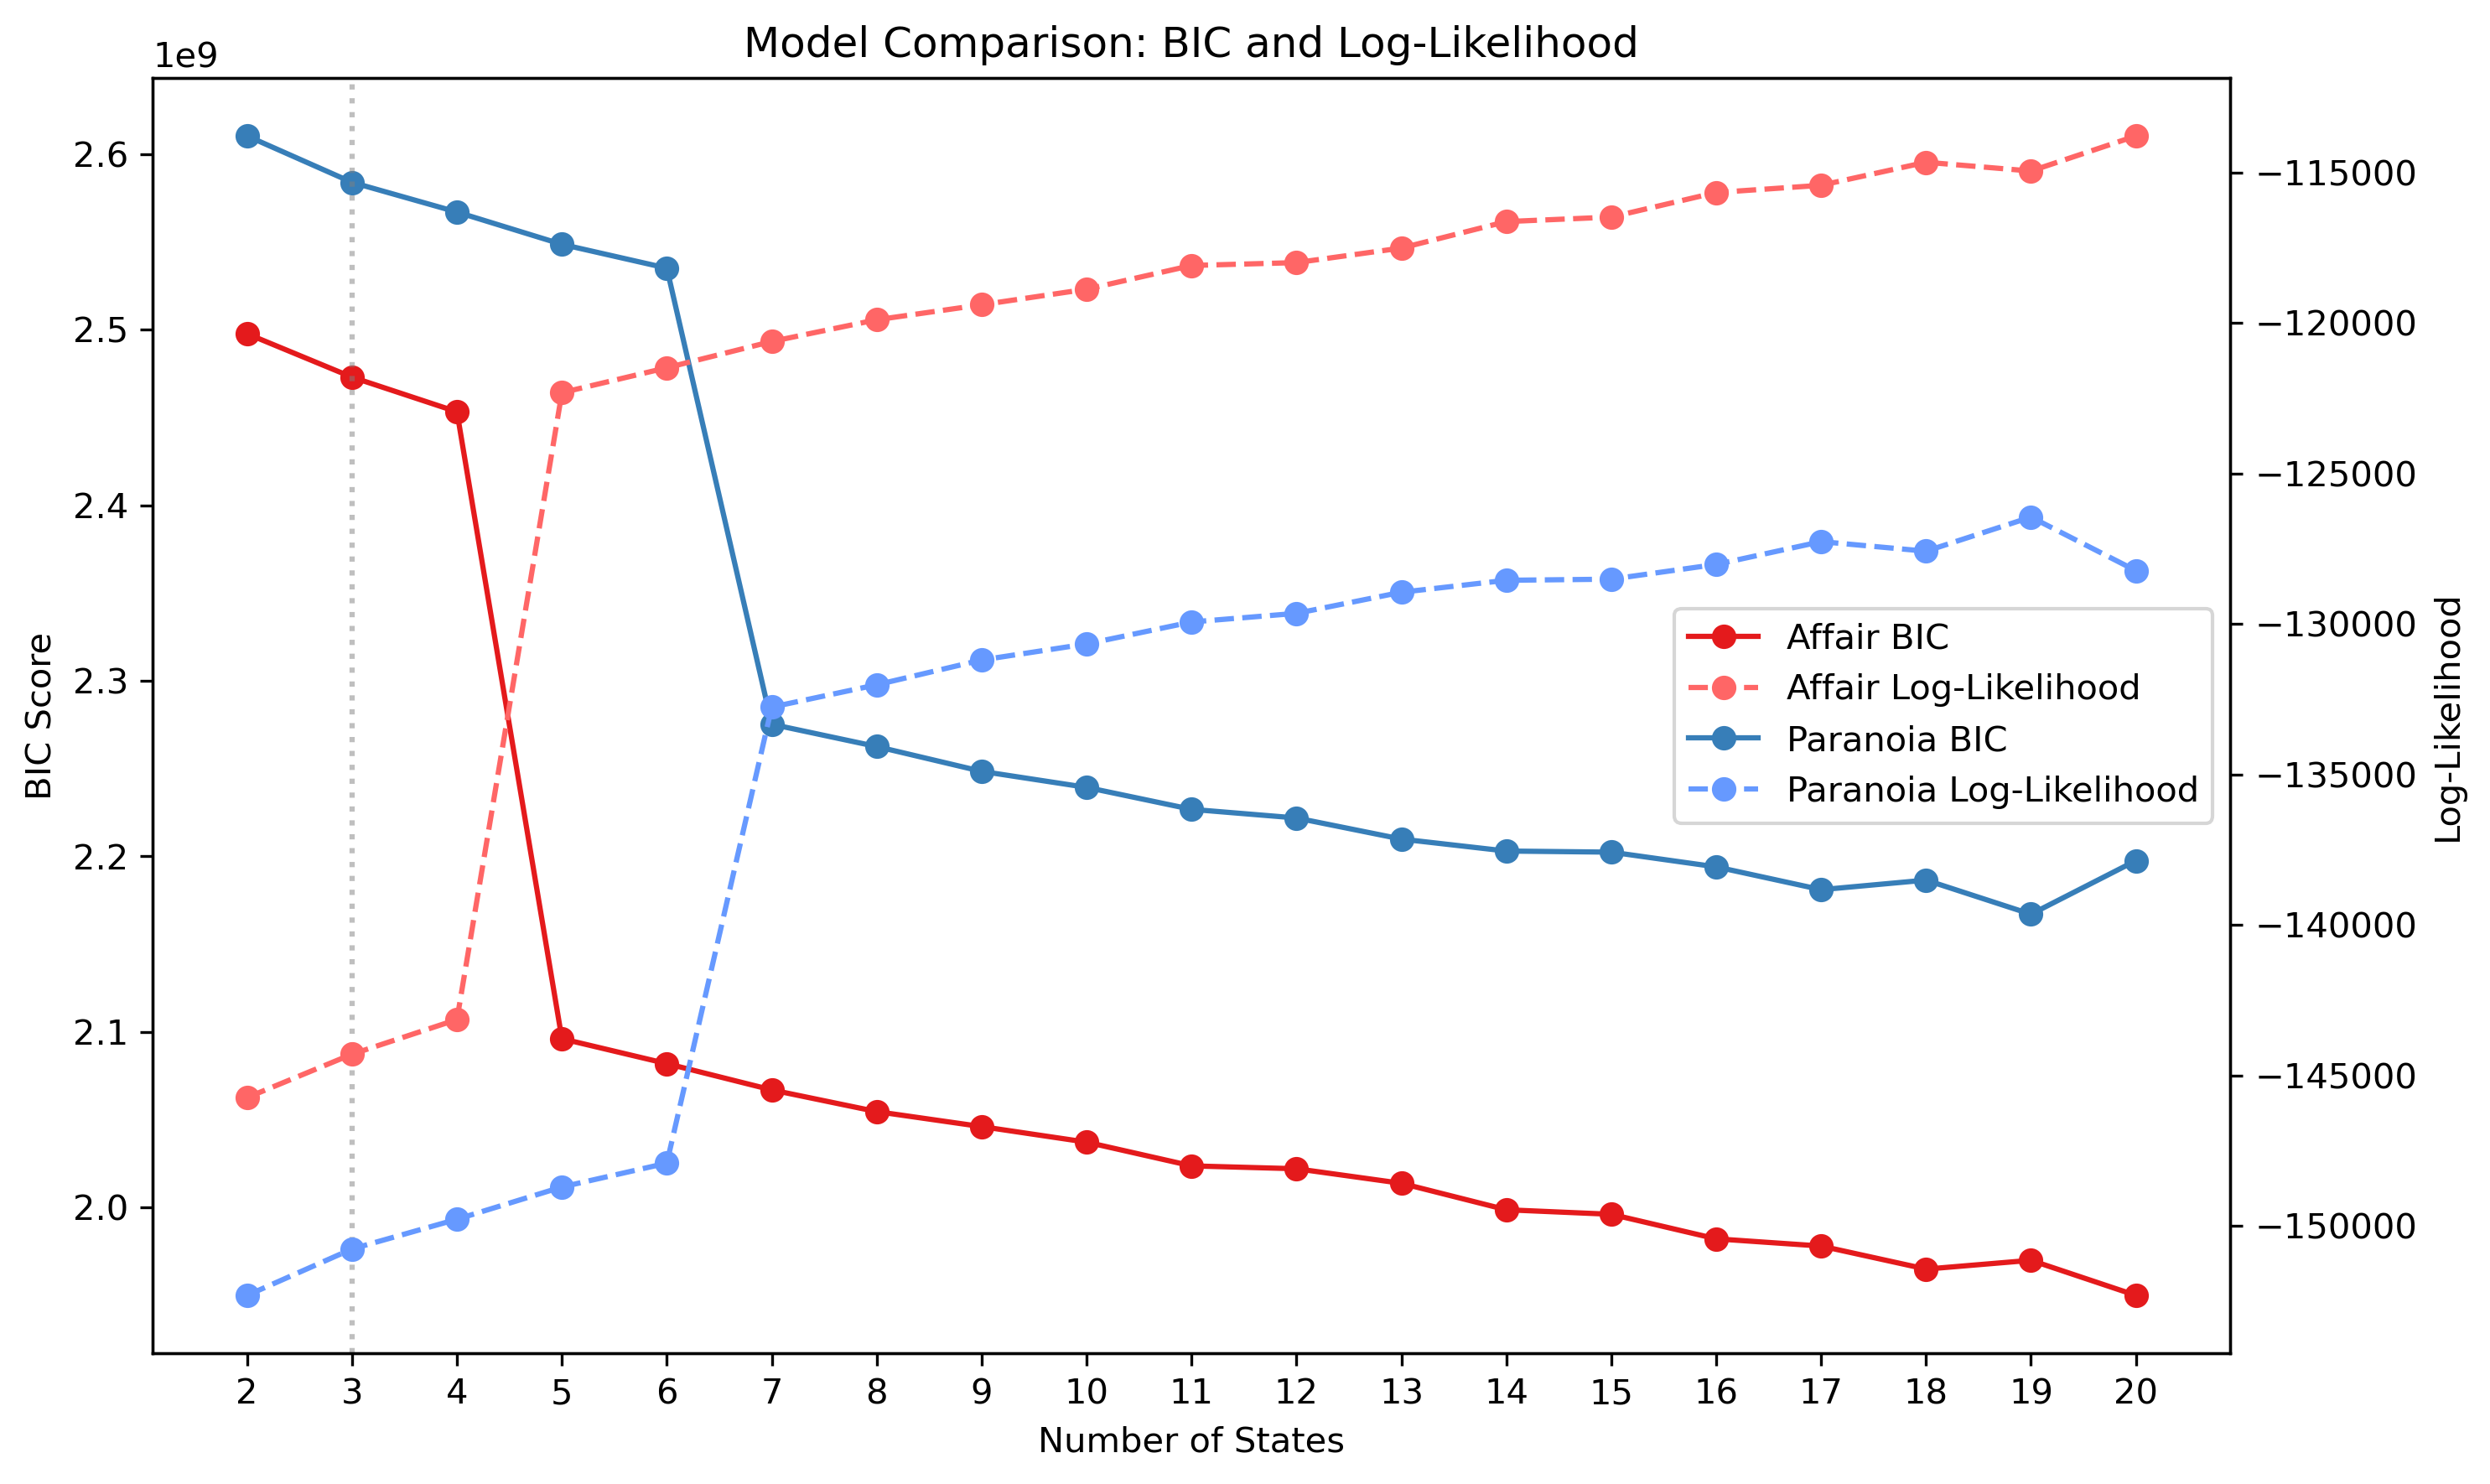

In [22]:
create_model_comparison_plot()

In [23]:
def create_stability_plot():
    """Create pattern stability comparison plot for both groups."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for group in GROUPS:
        data = []
        for n_state in N_STATES_RANGE:
            loaded_data = load_data(group, n_state)
            if loaded_data:
                metrics = extract_model_metrics(loaded_data)
                if metrics and 'mean_pattern_stability' in metrics:
                    data.append({
                        'n_states': n_state,
                        'stability': metrics['mean_pattern_stability']
                    })
        
        if data:
            df = pd.DataFrame(data)
            ax.plot(df['n_states'], df['stability'], 
                    color=COLORS[group], 
                    label=f'{group.capitalize()} Group',
                    marker='o')
    
    # Set x-axis to show all integer values
    ax.set_xticks(list(N_STATES_RANGE))
    
    ax.axvline(x=3, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Number of States')
    ax.set_ylabel('Mean Pattern Stability')
    ax.set_title('Model Comparison: Pattern Stability')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'pattern_stability.png', dpi=300, bbox_inches='tight')
    plt.close()

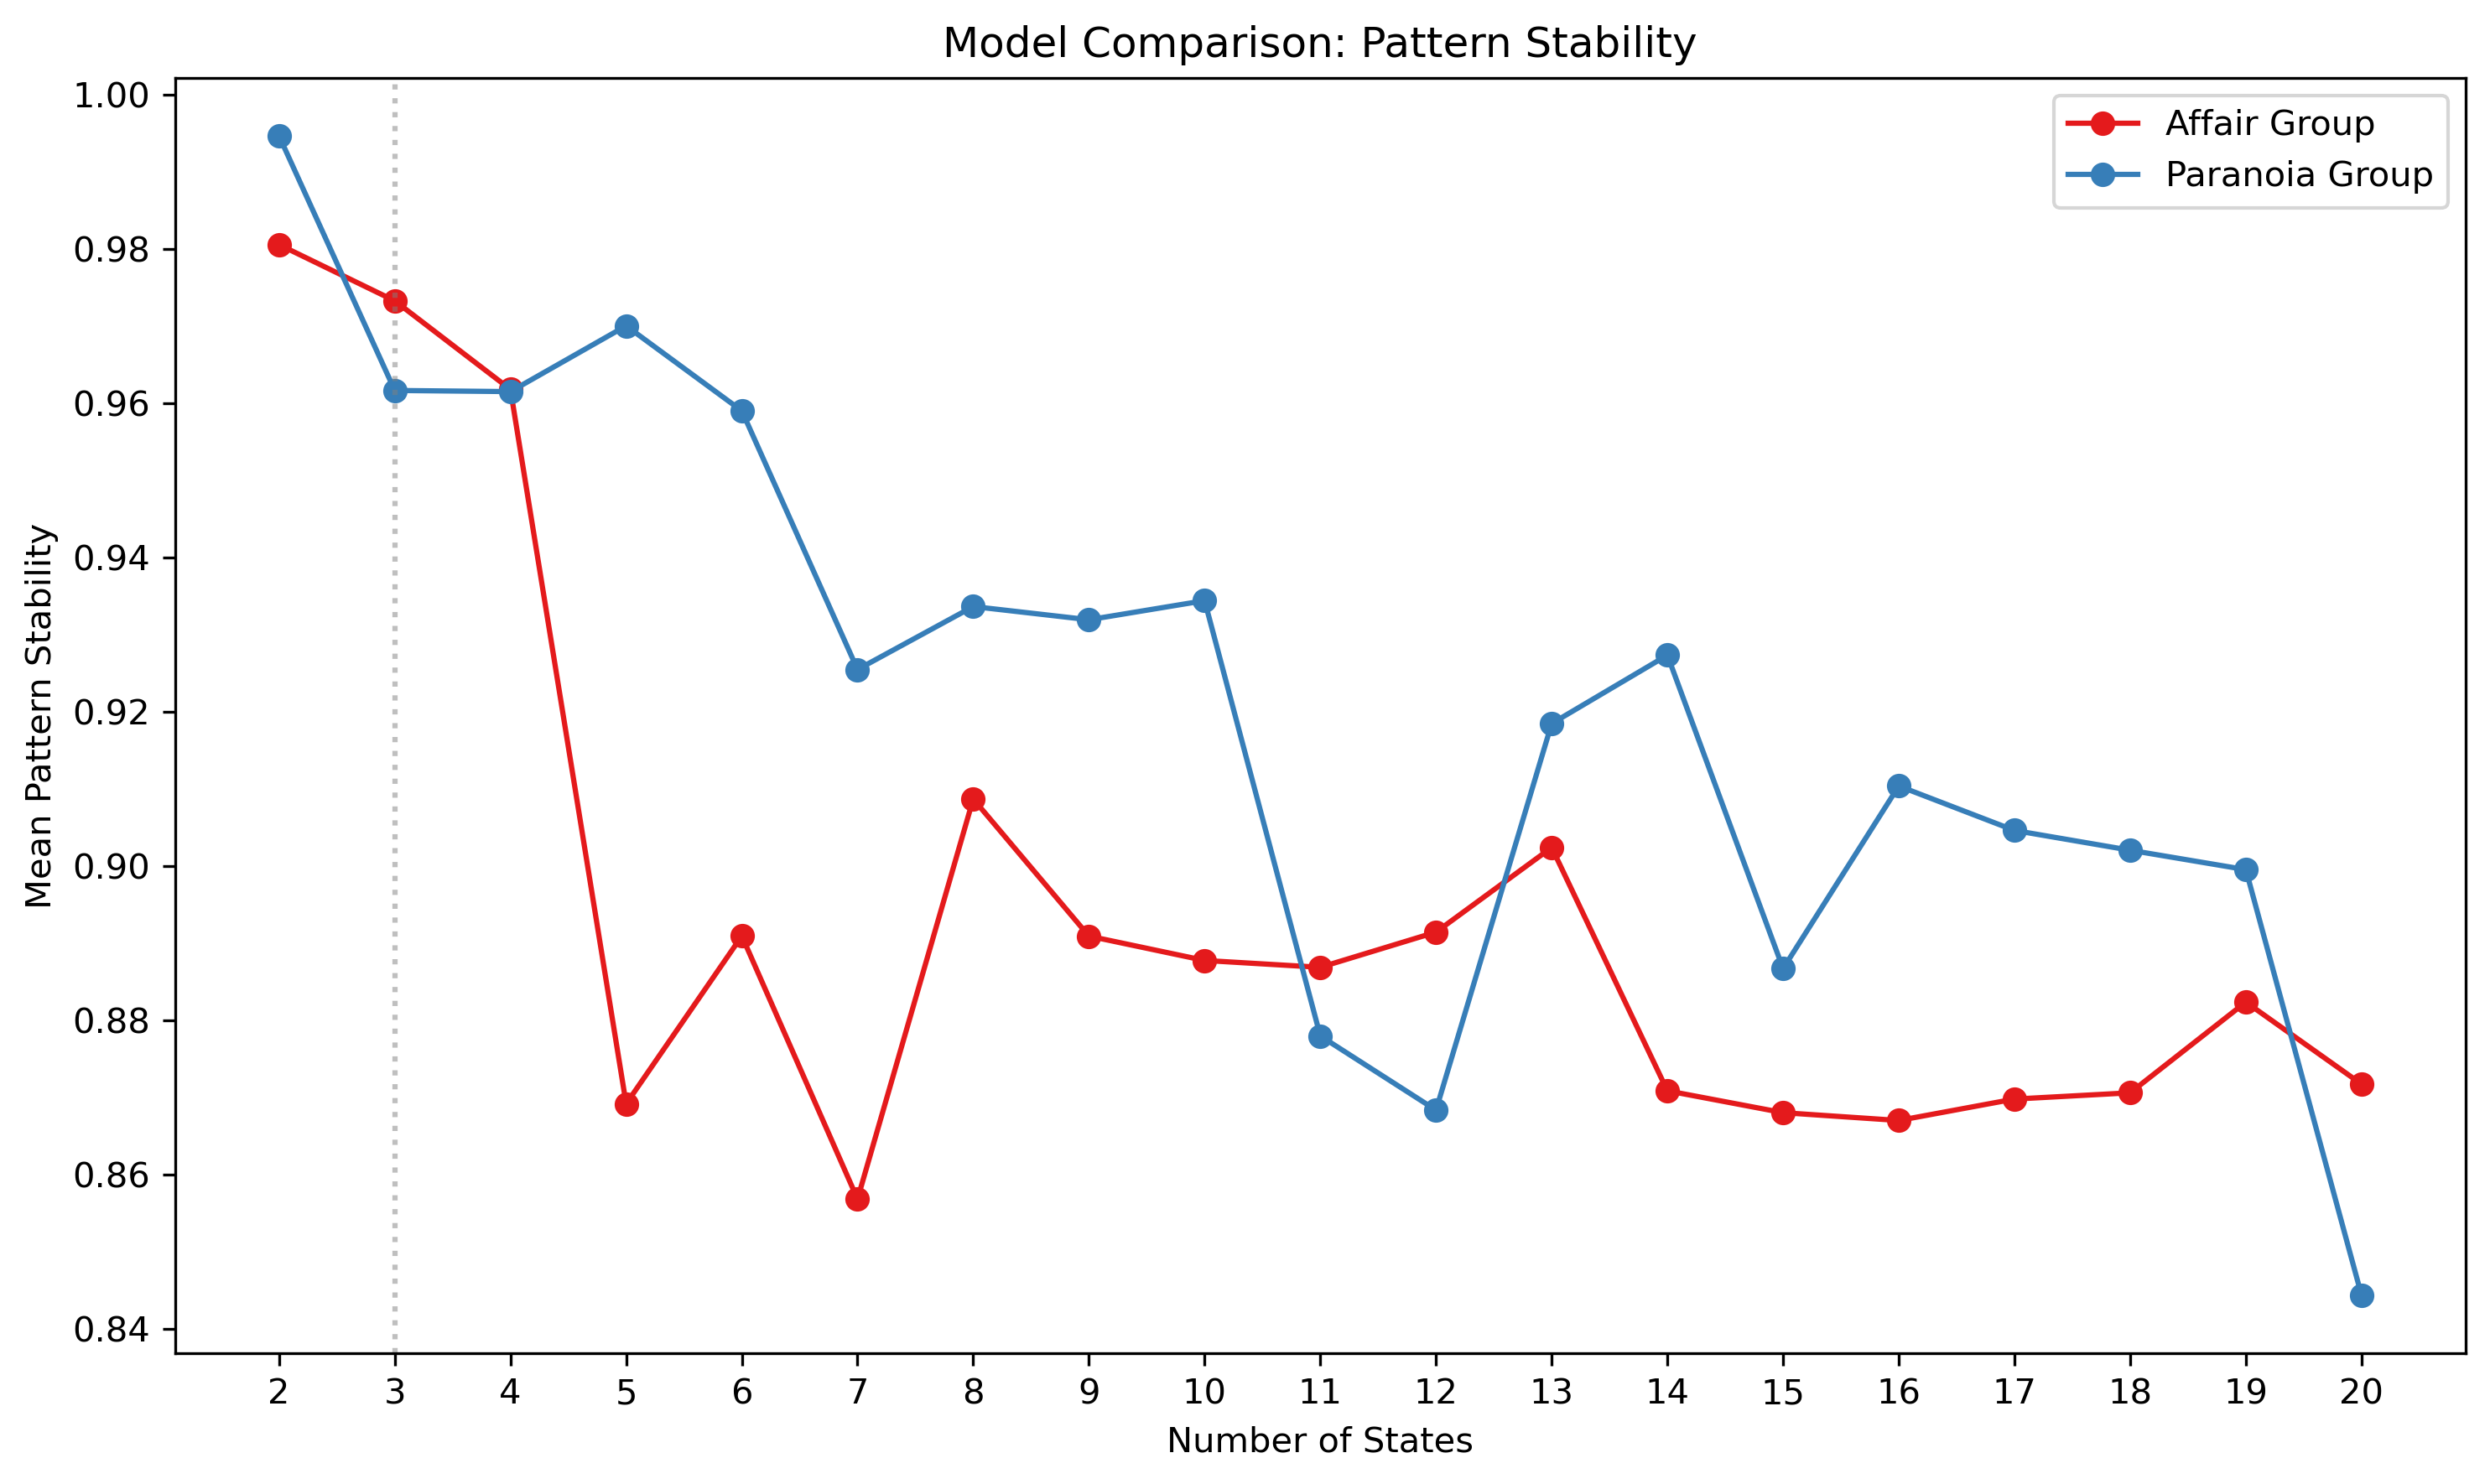

In [24]:
create_stability_plot()

### 2.3

In [25]:
# Load the saved results
with open(OUTPUT_DIR / "09_group_HMM_comparison" / "comparisons.pkl", 'rb') as f:
    results = pickle.load(f)


In [29]:
def plot_similarity():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sim_matrix = results['state_similarity']['similarity_matrix']
    matched_states = results['state_similarity']['matched_states']
    
    # Create heatmap
    sns.heatmap(sim_matrix,
                annot=True,
                cmap='viridis',
                vmin=0,
                vmax=1,
                fmt='.2f',
                ax=ax,
                xticklabels=['S1', 'S2', 'S3'],
                yticklabels=['S1', 'S2', 'S3'])
    
    # Mark matched states with red rectangles
    for i, j in matched_states:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,
                                 edgecolor='red', lw=2))
    
    ax.set_title('State Pattern Similarity', pad=20)
    ax.set_xlabel('Paranoia')
    ax.set_ylabel('Affair')
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'state_similarity.png', dpi=300, bbox_inches='tight')
    plt.close()

# Plot 2: Temporal Dynamics
def plot_temporal_dynamics():
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    matched_states = results['state_similarity']['matched_states']
    temporal_data = results['temporal_dynamics']
    
    for idx, (affair_idx, paranoia_idx) in enumerate(matched_states):
        ax = axes[idx]
        key = f'state_pair_{affair_idx}_{paranoia_idx}'
        profile = temporal_data[key]['temporal_profile']
        
        # Plot affair profile
        ax.plot(profile['affair_profile'],
               color=COLORS['affair'],
               label='Affair',
               linewidth=2)
        
        # Plot paranoia profile
        ax.plot(profile['paranoia_profile'],
               color=COLORS['paranoia'],
               label='Paranoia Reordered',
               linewidth=2,
               linestyle='--')
        
        ax.set_title(f'State {idx+1}')
        
        # Only show x-axis labels for the bottom plot
        if idx < 2:
            ax.set_xticks([])
        else:
            ax.set_xlabel('Time (TRs)')
        
        ax.set_ylabel('State Probability')
        ax.legend()
        
        # Set y-axis limits
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(SAVE_DIR_FIG2 / 'temporal_dynamics.png', dpi=300, bbox_inches='tight')
    plt.close()

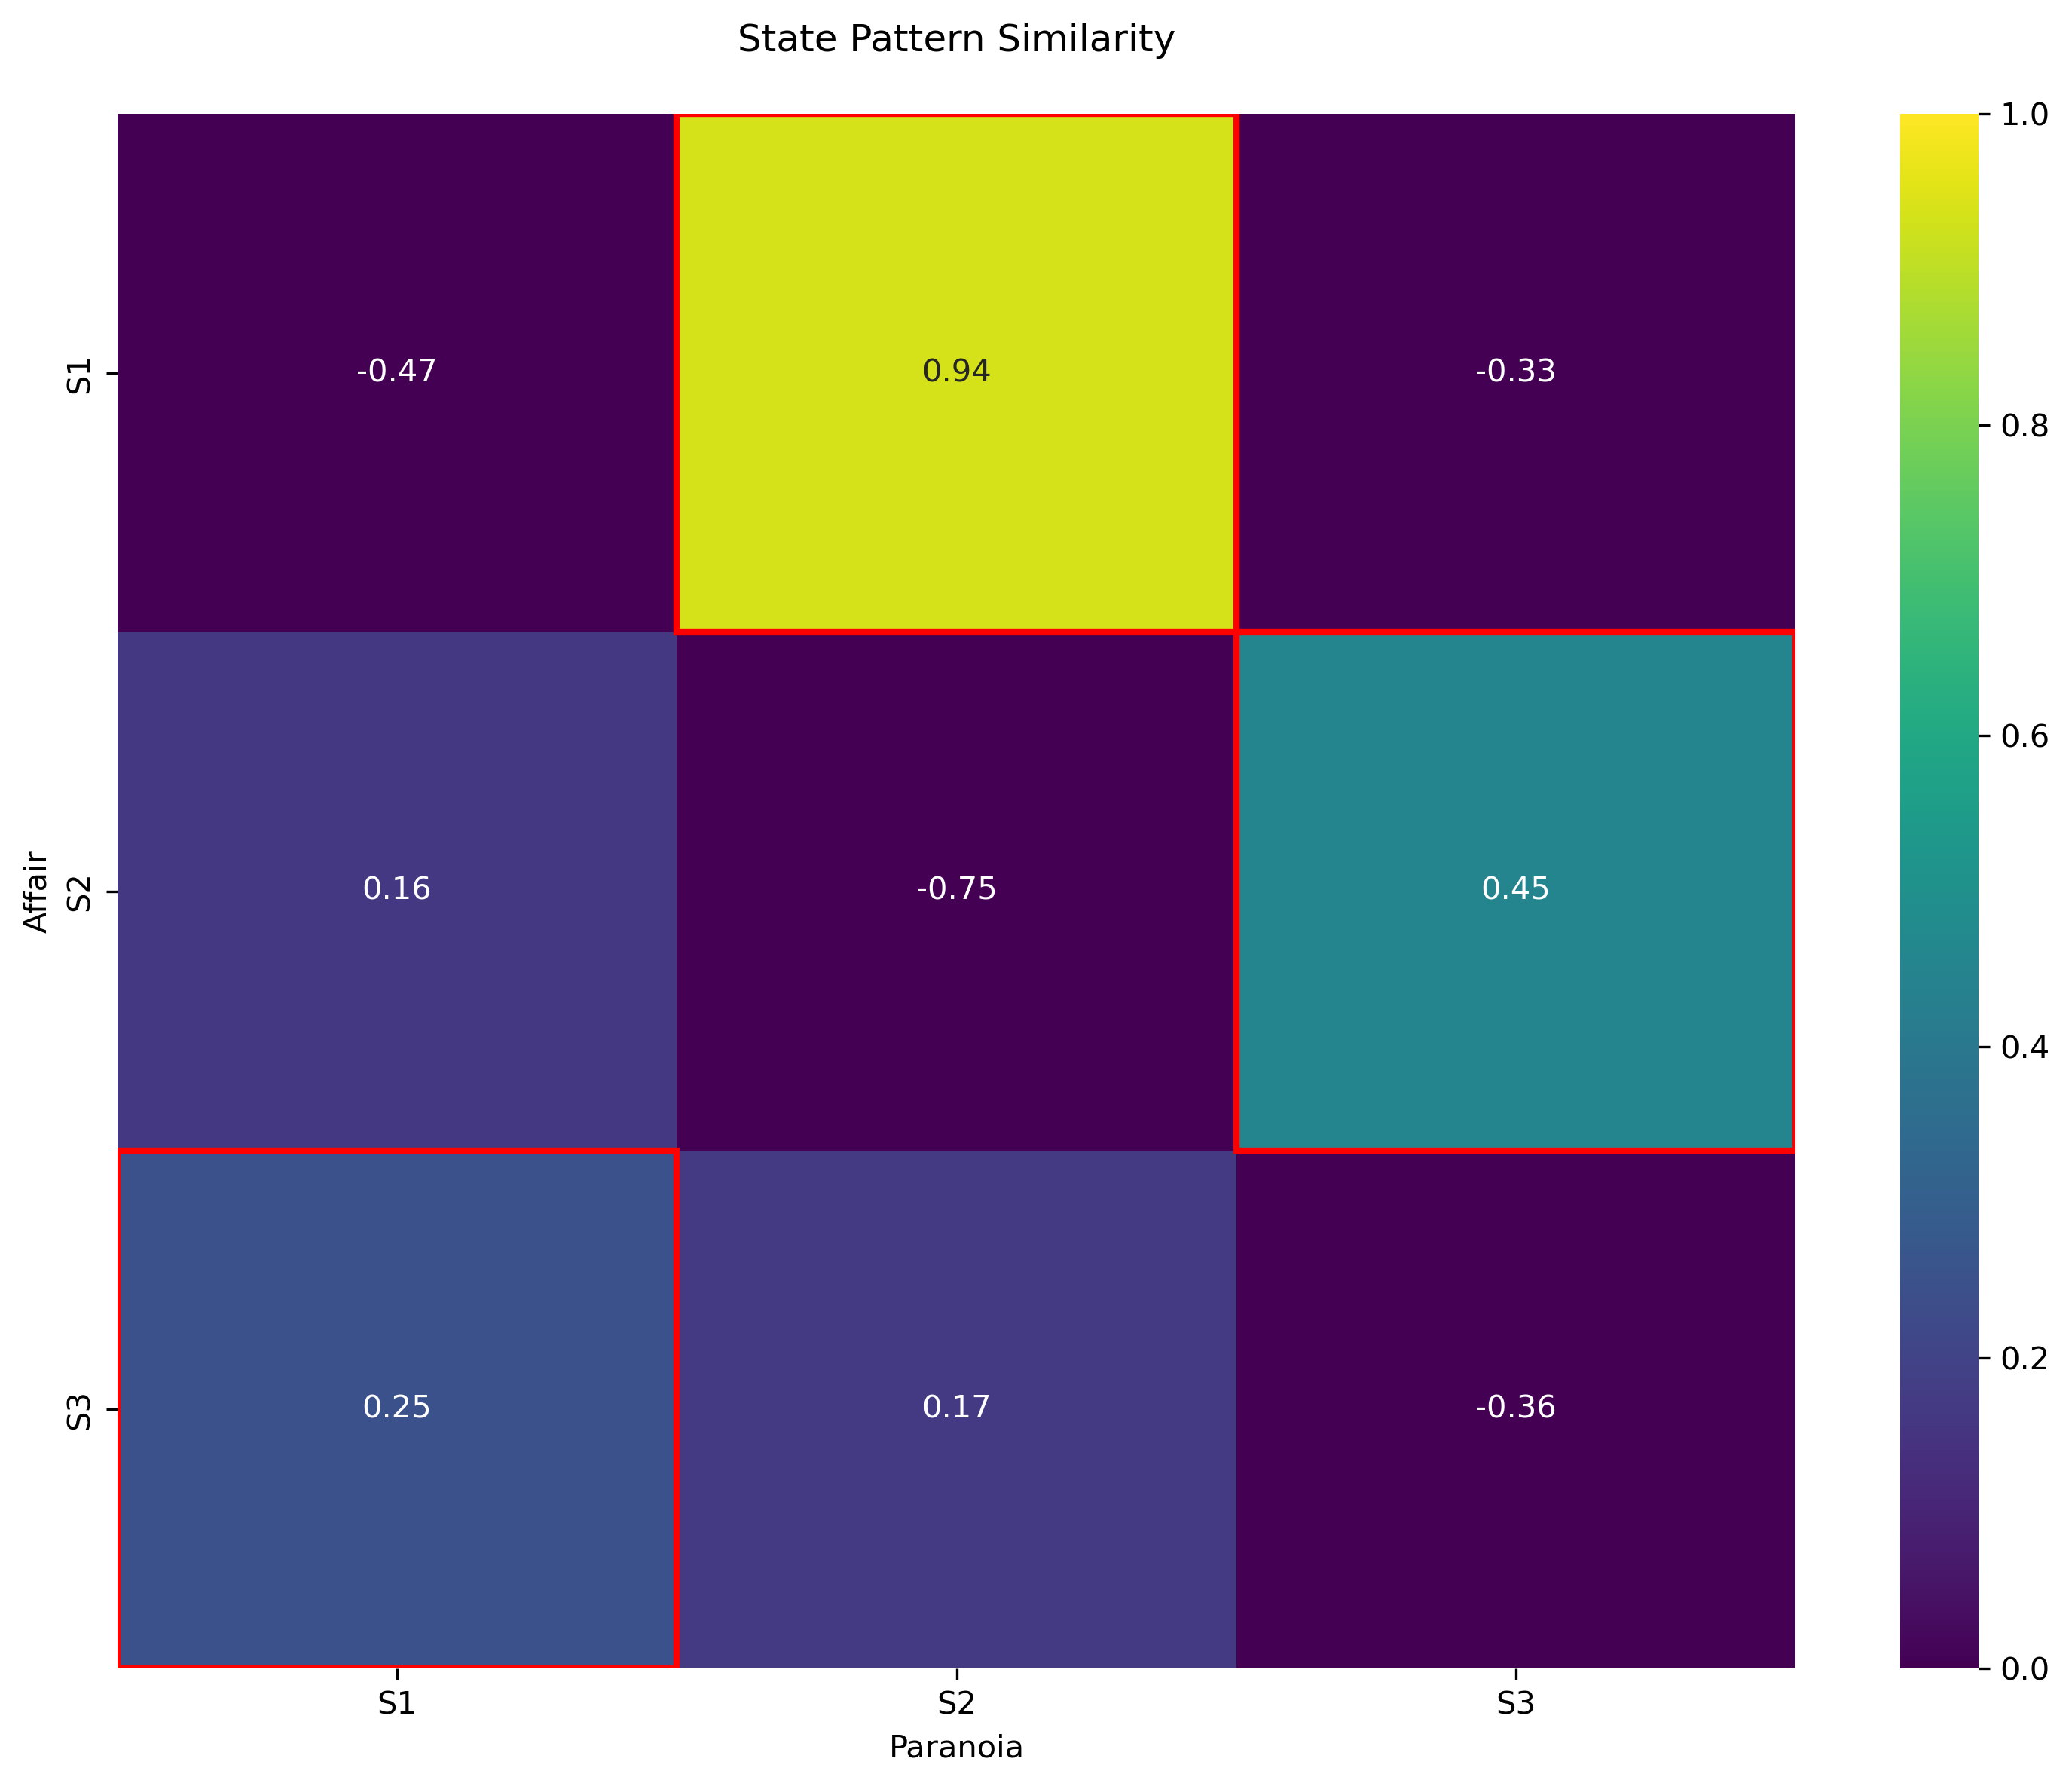

In [30]:
plot_similarity()

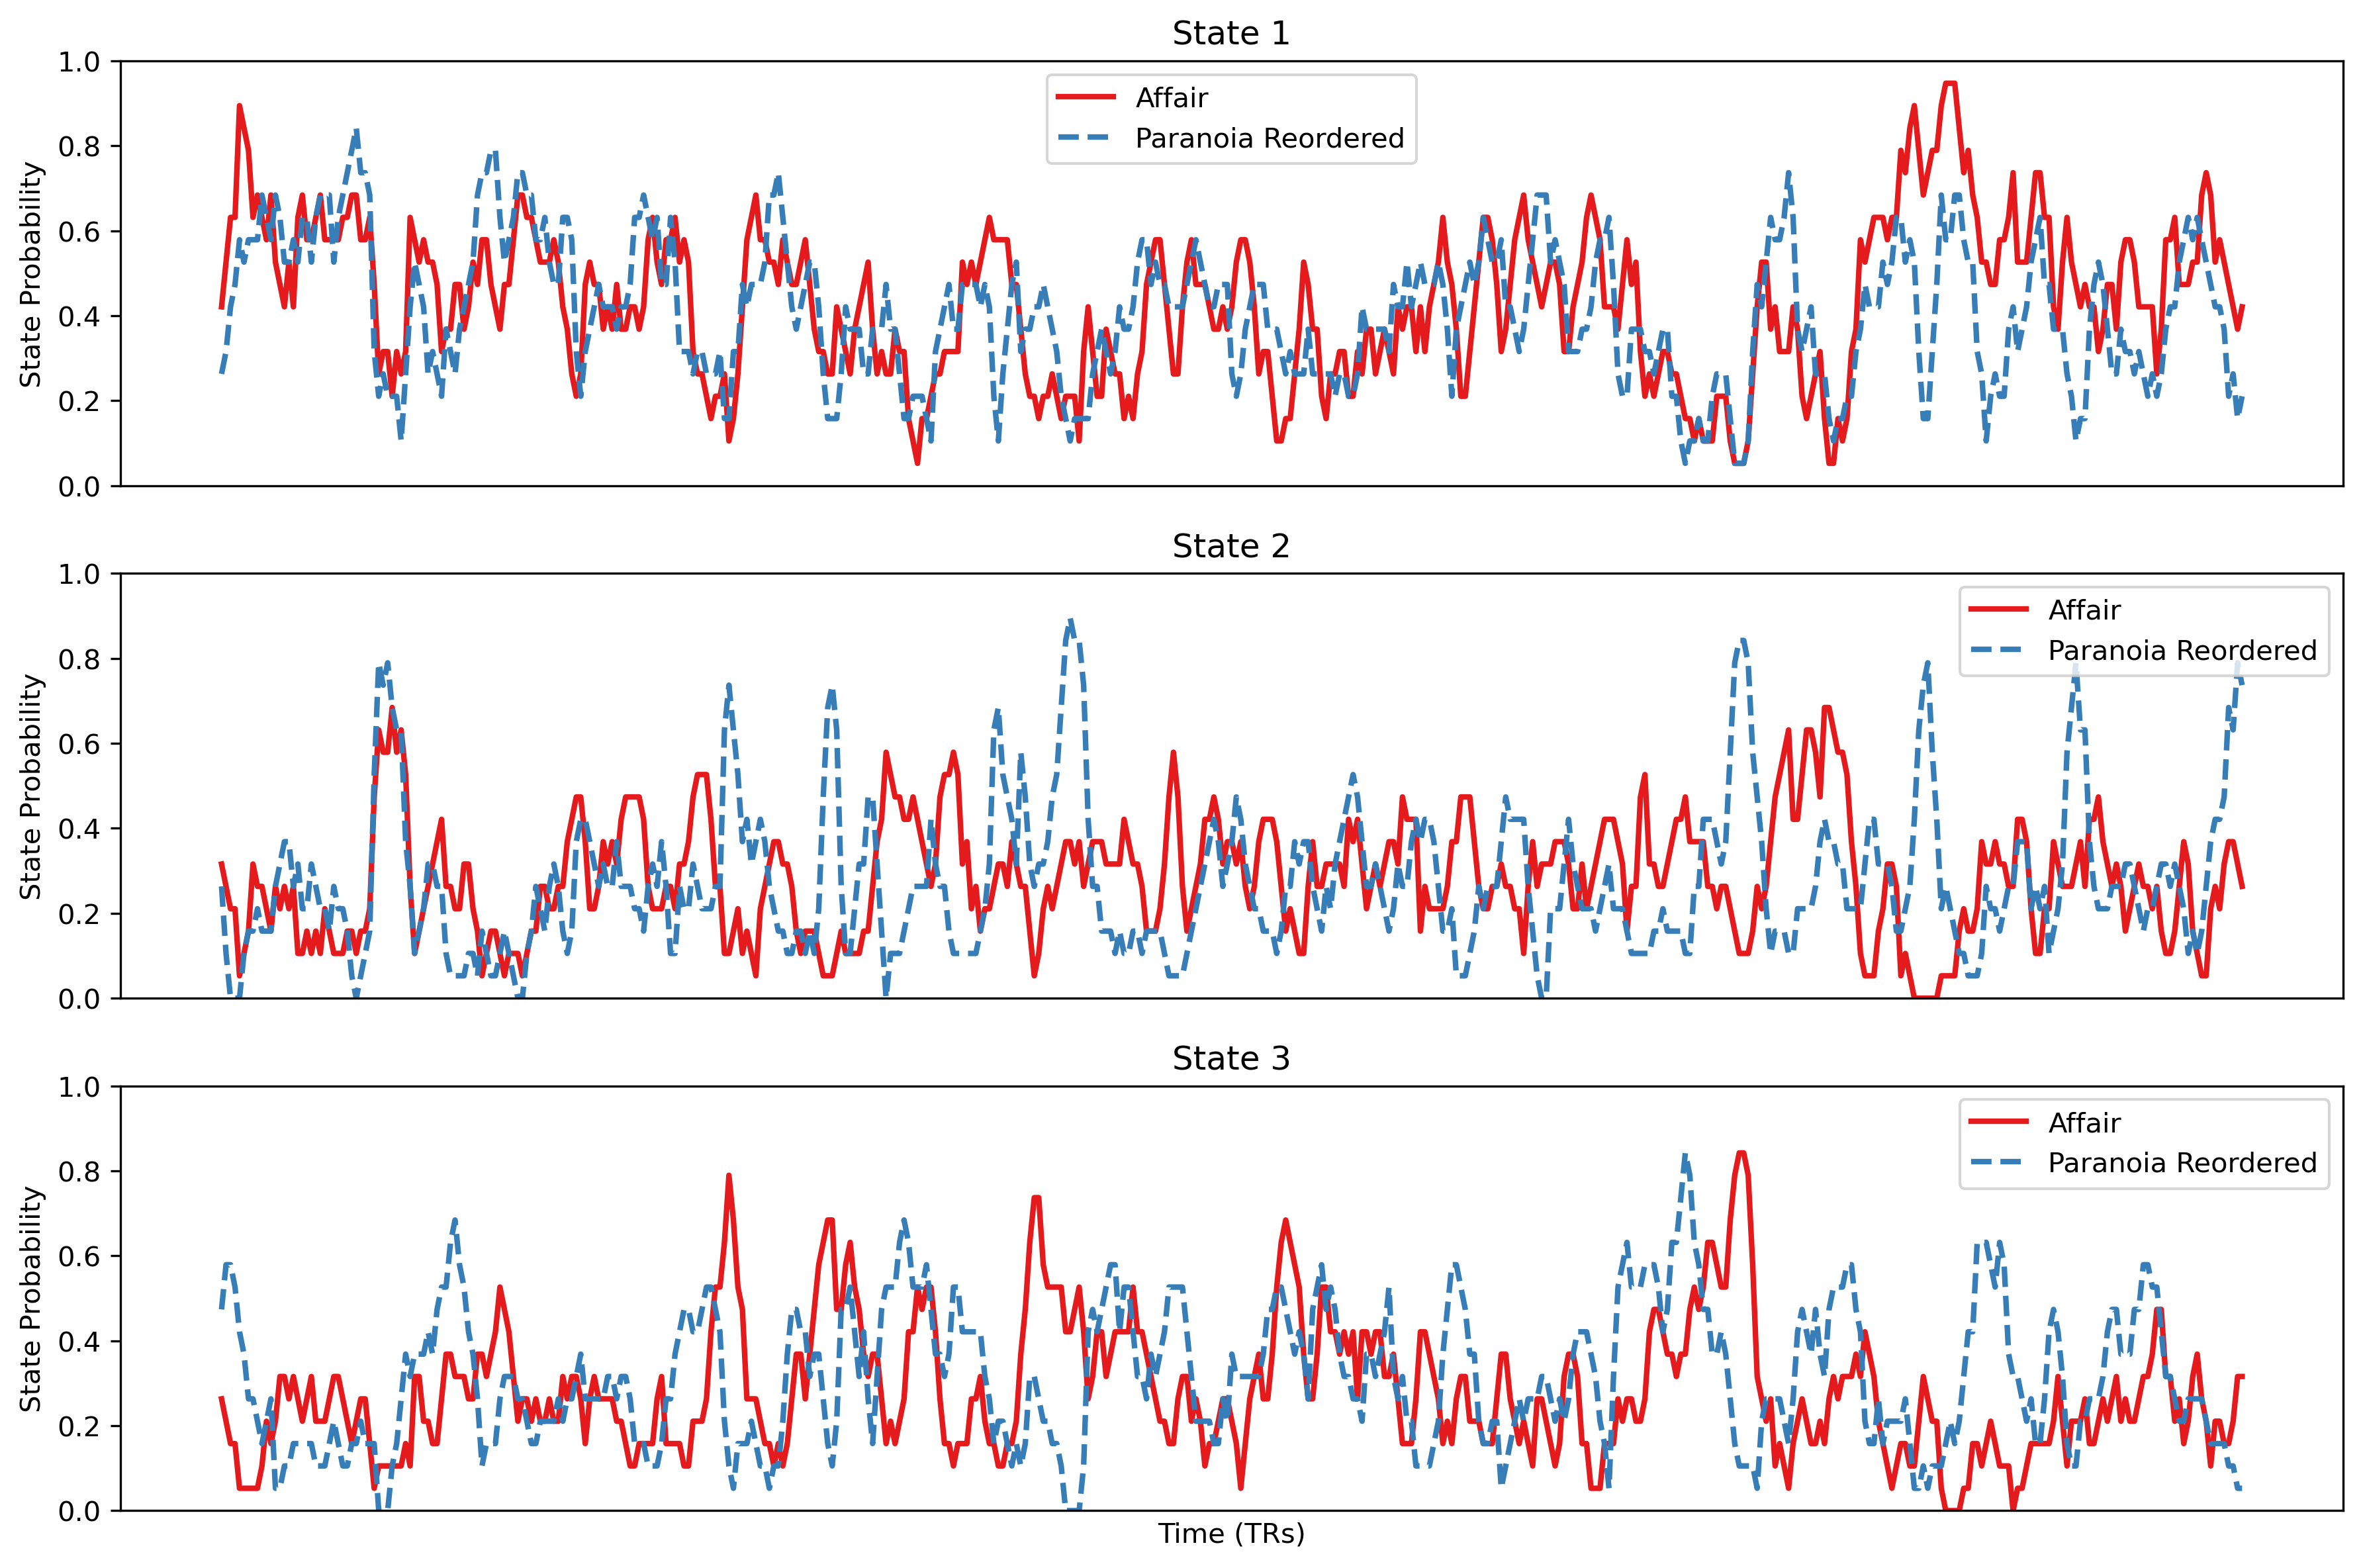

In [31]:
plot_temporal_dynamics()
